In [1]:
# 포토리소그래피 공정 센서 데이터 분석 및 이상 탐지
# SEMI_PHOTO_SENSORS 데이터 분석

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# =============================================
# 설정 (Configuration)
# =============================================

# CSV 파일 경로
CSV_FILE_PATH = '/home/minjoo/Github/PRISM-Monitor/prism_monitor/data/Industrial_DB_sample/SEMI_PHOTO_SENSORS.csv'

# 이상치 탐지 임계값
Z_SCORE_THRESHOLD = 3  # Z-score 임계값
TIME_WINDOW = '1H'     # 시간 구간별 분석 단위

# 한글 폰트 설정 (matplotlib)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("=" * 80)
print("포토리소그래피 공정 센서 데이터 분석 및 이상 탐지 시스템")
print("=" * 80)
print(f"설정된 CSV 파일 경로: {CSV_FILE_PATH}")
print(f"Z-score 임계값: {Z_SCORE_THRESHOLD}")
print(f"시간 구간 단위: {TIME_WINDOW}")

# 1. 데이터 로딩 및 전처리
print("\n1. 데이터 로딩 및 전처리")
print("-" * 50)

# CSV 파일 경로 설정
csv_file_path = CSV_FILE_PATH

# 파일 로딩
import os
if not os.path.exists(csv_file_path):
    raise FileNotFoundError(f"파일을 찾을 수 없습니다: {csv_file_path}")

print(f"CSV 파일을 로딩합니다: {csv_file_path}")
df = pd.read_csv(csv_file_path)
print("파일 로딩 성공!")

# TIMESTAMP 컬럼을 datetime 형태로 변환
if 'TIMESTAMP' not in df.columns:
    raise ValueError(f"TIMESTAMP 컬럼이 없습니다. 현재 컬럼들: {list(df.columns)}")

df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
print("TIMESTAMP 컬럼 변환 완료!")

# 데이터 기본 정보 출력
print(f"데이터 형태: {df.shape}")
print(f"컬럼 목록: {list(df.columns)}")

# 필수 컬럼 확인
required_columns = ['PNO', 'EQUIPMENT_ID', 'LOT_NO', 'WAFER_ID', 'TIMESTAMP', 
                   'EXPOSURE_DOSE', 'FOCUS_POSITION', 'STAGE_TEMP', 'BAROMETRIC_PRESSURE', 
                   'HUMIDITY', 'ALIGNMENT_ERROR_X', 'ALIGNMENT_ERROR_Y', 'LENS_ABERRATION', 
                   'ILLUMINATION_UNIFORMITY', 'RETICLE_TEMP']

missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"누락된 컬럼: {missing_columns}")
else:
    print("모든 필수 컬럼이 존재합니다!")

# 데이터 요약 정보
print(f"데이터 기간: {df['TIMESTAMP'].min()} ~ {df['TIMESTAMP'].max()}")
print(f"장비 수: {df['EQUIPMENT_ID'].nunique()}")
print(f"장비 목록: {list(df['EQUIPMENT_ID'].unique())}")
print(f"LOT 수: {df['LOT_NO'].nunique()}")

# 결측치 확인
missing_data = df.isnull().sum()
if missing_data.sum() > 0:
    print("결측치 발견:")
    print(missing_data[missing_data > 0])
else:
    print("결측치 없음!")

포토리소그래피 공정 센서 데이터 분석 및 이상 탐지 시스템
설정된 CSV 파일 경로: /home/minjoo/Github/PRISM-Monitor/prism_monitor/data/Industrial_DB_sample/SEMI_PHOTO_SENSORS.csv
Z-score 임계값: 3
시간 구간 단위: 1H

1. 데이터 로딩 및 전처리
--------------------------------------------------
CSV 파일을 로딩합니다: /home/minjoo/Github/PRISM-Monitor/prism_monitor/data/Industrial_DB_sample/SEMI_PHOTO_SENSORS.csv
파일 로딩 성공!
TIMESTAMP 컬럼 변환 완료!
데이터 형태: (35, 15)
컬럼 목록: ['PNO', 'EQUIPMENT_ID', 'LOT_NO', 'WAFER_ID', 'TIMESTAMP', 'EXPOSURE_DOSE', 'FOCUS_POSITION', 'STAGE_TEMP', 'BAROMETRIC_PRESSURE', 'HUMIDITY', 'ALIGNMENT_ERROR_X', 'ALIGNMENT_ERROR_Y', 'LENS_ABERRATION', 'ILLUMINATION_UNIFORMITY', 'RETICLE_TEMP']
모든 필수 컬럼이 존재합니다!
데이터 기간: 2024-01-15 08:30:15 ~ 2024-02-02 08:46:05
장비 수: 3
장비 목록: ['PHO_001', 'PHO_002', 'PHO_003']
LOT 수: 13
결측치 없음!


In [3]:
# 2. 정상 범위 정의
print("\n2. 정상 범위 정의")
print("-" * 50)

# 정상 범위 딕셔너리 정의
normal_ranges = {
    'EXPOSURE_DOSE': (20, 40),  # 20-40 mJ/cm²
    'FOCUS_POSITION': (-50, 50),  # ±50 nm
    'STAGE_TEMP': (22.9, 23.1),  # 23±0.1 °C
    'HUMIDITY': (40, 50),  # 45±5 %
    'ALIGNMENT_ERROR_X': (0, 3),  # <3 nm
    'ALIGNMENT_ERROR_Y': (0, 3),  # <3 nm
    'LENS_ABERRATION': (0, 5),  # <5 mλ
    'ILLUMINATION_UNIFORMITY': (98, 100),  # >98 %
    'RETICLE_TEMP': (22.95, 23.05)  # 23±0.05 °C
}

print("정상 범위 설정:")
for param, (min_val, max_val) in normal_ranges.items():
    print(f"  {param}: {min_val} ~ {max_val}")



2. 정상 범위 정의
--------------------------------------------------
정상 범위 설정:
  EXPOSURE_DOSE: 20 ~ 40
  FOCUS_POSITION: -50 ~ 50
  STAGE_TEMP: 22.9 ~ 23.1
  HUMIDITY: 40 ~ 50
  ALIGNMENT_ERROR_X: 0 ~ 3
  ALIGNMENT_ERROR_Y: 0 ~ 3
  LENS_ABERRATION: 0 ~ 5
  ILLUMINATION_UNIFORMITY: 98 ~ 100
  RETICLE_TEMP: 22.95 ~ 23.05


In [4]:
# 3. 기본 통계 분석
print("\n3. 기본 통계 분석")
print("-" * 50)

# 주요 센서 파라미터들의 기본 통계
sensor_columns = list(normal_ranges.keys())
print("주요 센서 파라미터 기본 통계:")
print(df[sensor_columns].describe().round(3))


3. 기본 통계 분석
--------------------------------------------------
주요 센서 파라미터 기본 통계:
       EXPOSURE_DOSE  FOCUS_POSITION  STAGE_TEMP  HUMIDITY  ALIGNMENT_ERROR_X  \
count         35.000          35.000      35.000    35.000             35.000   
mean          32.203          -8.117      23.050    44.863              1.871   
std            2.556          15.295       0.023     0.295              0.424   
min           28.600         -28.500      23.010    44.200              1.200   
25%           29.950         -18.950      23.035    44.700              1.500   
50%           32.300         -15.300      23.050    44.900              1.900   
75%           33.950           9.950      23.070    45.100              2.100   
max           37.200          13.800      23.090    45.400              2.800   

       ALIGNMENT_ERROR_Y  LENS_ABERRATION  ILLUMINATION_UNIFORMITY  \
count             35.000           35.000                   35.000   
mean               2.029            3.317       

In [5]:
# 4. 정상 범위 기반 이상치 탐지
print("\n4. 정상 범위 기반 이상치 탐지")
print("-" * 50)

def detect_range_anomalies(df, normal_ranges):
    """정상 범위를 벗어나는 이상치 탐지"""
    anomalies = pd.DataFrame()
    anomaly_summary = {}
    
    for param, (min_val, max_val) in normal_ranges.items():
        # 범위를 벗어나는 데이터 찾기
        out_of_range = (df[param] < min_val) | (df[param] > max_val)
        if out_of_range.any():
            anomaly_data = df[out_of_range].copy()
            anomaly_data['ANOMALY_TYPE'] = f'{param}_OUT_OF_RANGE'
            anomaly_data['ANOMALY_VALUE'] = df.loc[out_of_range, param]
            anomaly_data['NORMAL_MIN'] = min_val
            anomaly_data['NORMAL_MAX'] = max_val
            anomalies = pd.concat([anomalies, anomaly_data], ignore_index=True)
            
            anomaly_summary[param] = {
                'count': out_of_range.sum(),
                'percentage': (out_of_range.sum() / len(df)) * 100,
                'min_detected': df.loc[out_of_range, param].min() if out_of_range.any() else None,
                'max_detected': df.loc[out_of_range, param].max() if out_of_range.any() else None
            }
    
    return anomalies, anomaly_summary

# 정상 범위 기반 이상치 탐지 실행
range_anomalies, range_summary = detect_range_anomalies(df, normal_ranges)

print("정상 범위 벗어난 이상치 요약:")
for param, summary in range_summary.items():
    print(f"  {param}:")
    print(f"    - 이상치 개수: {summary['count']}개 ({summary['percentage']:.1f}%)")
    print(f"    - 탐지된 값 범위: {summary['min_detected']:.3f} ~ {summary['max_detected']:.3f}")



4. 정상 범위 기반 이상치 탐지
--------------------------------------------------
정상 범위 벗어난 이상치 요약:
  ILLUMINATION_UNIFORMITY:
    - 이상치 개수: 4개 (11.4%)
    - 탐지된 값 범위: 97.600 ~ 97.900
  RETICLE_TEMP:
    - 이상치 개수: 2개 (5.7%)
    - 탐지된 값 범위: 23.060 ~ 23.070


In [6]:
# 5. 통계적 이상치 탐지 (Z-score 기반)
print("\n5. 통계적 이상치 탐지 (Z-score)")
print("-" * 50)

def detect_statistical_anomalies(df, sensor_columns, z_threshold=3):
    """Z-score 기반 통계적 이상치 탐지"""
    anomalies = pd.DataFrame()
    anomaly_summary = {}
    
    for param in sensor_columns:
        # Z-score 계산
        z_scores = np.abs((df[param] - df[param].mean()) / df[param].std())
        outliers = z_scores > z_threshold
        
        if outliers.any():
            anomaly_data = df[outliers].copy()
            anomaly_data['ANOMALY_TYPE'] = f'{param}_STATISTICAL_OUTLIER'
            anomaly_data['Z_SCORE'] = z_scores[outliers]
            anomaly_data['ANOMALY_VALUE'] = df.loc[outliers, param]
            anomalies = pd.concat([anomalies, anomaly_data], ignore_index=True)
            
            anomaly_summary[param] = {
                'count': outliers.sum(),
                'percentage': (outliers.sum() / len(df)) * 100,
                'max_z_score': z_scores[outliers].max()
            }
    
    return anomalies, anomaly_summary

# 통계적 이상치 탐지 실행
stat_anomalies, stat_summary = detect_statistical_anomalies(df, sensor_columns, Z_SCORE_THRESHOLD)

print(f"통계적 이상치 요약 (Z-score > {Z_SCORE_THRESHOLD}):")
for param, summary in stat_summary.items():
    print(f"  {param}:")
    print(f"    - 이상치 개수: {summary['count']}개 ({summary['percentage']:.1f}%)")
    print(f"    - 최대 Z-score: {summary['max_z_score']:.2f}")


5. 통계적 이상치 탐지 (Z-score)
--------------------------------------------------
통계적 이상치 요약 (Z-score > 3):


In [7]:
# 6. 시간 구간별 이상 이벤트 탐지
print("\n6. 시간 구간별 이상 이벤트 탐지")
print("-" * 50)

def detect_time_based_anomalies(df, time_window='1H'):
    """시간 구간별 이상 이벤트 탐지"""
    df_grouped = df.set_index('TIMESTAMP').groupby([
        pd.Grouper(freq=time_window), 'EQUIPMENT_ID'
    ])
    
    time_anomalies = []
    
    for (time_group, equipment), group_data in df_grouped:
        if len(group_data) == 0:
            continue
            
        # 각 시간 구간에서 정상 범위 벗어난 파라미터 수 계산
        anomaly_count = 0
        anomaly_details = []
        
        for param, (min_val, max_val) in normal_ranges.items():
            out_of_range = ((group_data[param] < min_val) | 
                          (group_data[param] > max_val)).sum()
            if out_of_range > 0:
                anomaly_count += out_of_range
                anomaly_details.append(f"{param}({out_of_range})")
        
        if anomaly_count > 0:
            time_anomalies.append({
                'TIME_WINDOW': time_group,
                'EQUIPMENT_ID': equipment,
                'TOTAL_ANOMALIES': anomaly_count,
                'TOTAL_MEASUREMENTS': len(group_data),
                'ANOMALY_RATE': anomaly_count / len(group_data) * 100,
                'ANOMALY_DETAILS': ', '.join(anomaly_details)
            })
    
    return pd.DataFrame(time_anomalies)

# 시간 구간별 이상 탐지 실행
time_anomalies = detect_time_based_anomalies(df, TIME_WINDOW)

print("시간 구간별 이상 이벤트:")
if not time_anomalies.empty:
    for _, row in time_anomalies.iterrows():
        print(f"  {row['TIME_WINDOW'].strftime('%Y-%m-%d %H:%M')} - {row['EQUIPMENT_ID']}:")
        print(f"    - 이상치: {row['TOTAL_ANOMALIES']}개/{row['TOTAL_MEASUREMENTS']}개 측정 ({row['ANOMALY_RATE']:.1f}%)")
        print(f"    - 세부사항: {row['ANOMALY_DETAILS']}")
else:
    print("  시간 구간별 집계된 이상 이벤트 없음")


6. 시간 구간별 이상 이벤트 탐지
--------------------------------------------------
시간 구간별 이상 이벤트:
  2024-01-23 08:00 - PHO_003:
    - 이상치: 3개/2개 측정 (150.0%)
    - 세부사항: ILLUMINATION_UNIFORMITY(2), RETICLE_TEMP(1)
  2024-02-01 12:00 - PHO_003:
    - 이상치: 3개/2개 측정 (150.0%)
    - 세부사항: ILLUMINATION_UNIFORMITY(2), RETICLE_TEMP(1)


In [8]:
# 7. 장비별 성능 분석
print("\n7. 장비별 성능 분석")
print("-" * 50)

def analyze_equipment_performance(df, normal_ranges):
    """장비별 성능 분석"""
    equipment_analysis = {}
    
    for equipment in df['EQUIPMENT_ID'].unique():
        eq_data = df[df['EQUIPMENT_ID'] == equipment]
        analysis = {
            'total_measurements': len(eq_data),
            'total_anomalies': 0,
            'parameter_anomalies': {}
        }
        
        for param, (min_val, max_val) in normal_ranges.items():
            out_of_range = ((eq_data[param] < min_val) | 
                          (eq_data[param] > max_val)).sum()
            analysis['parameter_anomalies'][param] = out_of_range
            analysis['total_anomalies'] += out_of_range
        
        analysis['anomaly_rate'] = (analysis['total_anomalies'] / 
                                  (analysis['total_measurements'] * len(normal_ranges))) * 100
        
        equipment_analysis[equipment] = analysis
    
    return equipment_analysis

# 장비별 성능 분석 실행
equipment_performance = analyze_equipment_performance(df, normal_ranges)

print("장비별 성능 요약:")
for equipment, analysis in equipment_performance.items():
    print(f"  {equipment}:")
    print(f"    - 총 측정: {analysis['total_measurements']}회")
    print(f"    - 총 이상치: {analysis['total_anomalies']}개")
    print(f"    - 이상률: {analysis['anomaly_rate']:.2f}%")
    
    # 가장 많은 이상치를 보인 파라미터 찾기
    max_anomaly_param = max(analysis['parameter_anomalies'], 
                           key=analysis['parameter_anomalies'].get)
    max_anomaly_count = analysis['parameter_anomalies'][max_anomaly_param]
    if max_anomaly_count > 0:
        print(f"    - 최다 이상 파라미터: {max_anomaly_param} ({max_anomaly_count}개)")



7. 장비별 성능 분석
--------------------------------------------------
장비별 성능 요약:
  PHO_001:
    - 총 측정: 12회
    - 총 이상치: 0개
    - 이상률: 0.00%
  PHO_002:
    - 총 측정: 13회
    - 총 이상치: 0개
    - 이상률: 0.00%
  PHO_003:
    - 총 측정: 10회
    - 총 이상치: 6개
    - 이상률: 6.67%
    - 최다 이상 파라미터: ILLUMINATION_UNIFORMITY (4개)


In [9]:
# 8. 종합 이상 탐지 함수
print("\n8. 종합 이상 탐지 시스템")
print("-" * 50)

def comprehensive_anomaly_detection(df, start_time=None, end_time=None):
    """
    주어진 시간 구간에서 종합적인 이상 탐지를 수행
    
    Parameters:
    - df: 데이터프레임
    - start_time: 시작 시간 (문자열 또는 datetime)
    - end_time: 종료 시간 (문자열 또는 datetime)
    
    Returns:
    - 탐지된 이상 이벤트들과 요약 정보
    """
    
    # 시간 구간 필터링
    if start_time or end_time:
        filtered_df = df.copy()
        if start_time:
            start_time = pd.to_datetime(start_time)
            filtered_df = filtered_df[filtered_df['TIMESTAMP'] >= start_time]
        if end_time:
            end_time = pd.to_datetime(end_time)
            filtered_df = filtered_df[filtered_df['TIMESTAMP'] <= end_time]
    else:
        filtered_df = df.copy()
    
    if len(filtered_df) == 0:
        return {"message": "지정된 시간 구간에 데이터가 없습니다."}
    
    # 1. 정상 범위 기반 이상치 탐지
    range_anomalies, range_summary = detect_range_anomalies(filtered_df, normal_ranges)
    
    # 2. 통계적 이상치 탐지
    stat_anomalies, stat_summary = detect_statistical_anomalies(filtered_df, sensor_columns)
    
    # 3. 장비별 분석
    equipment_analysis = analyze_equipment_performance(filtered_df, normal_ranges)
    
    # 결과 종합
    result = {
        'analysis_period': {
            'start': filtered_df['TIMESTAMP'].min(),
            'end': filtered_df['TIMESTAMP'].max(),
            'total_measurements': len(filtered_df)
        },
        'range_based_anomalies': {
            'count': len(range_anomalies),
            'summary': range_summary,
            'details': range_anomalies
        },
        'statistical_anomalies': {
            'count': len(stat_anomalies),
            'summary': stat_summary,
            'details': stat_anomalies
        },
        'equipment_performance': equipment_analysis,
        'overall_status': 'NORMAL' if len(range_anomalies) == 0 else 'ANOMALY_DETECTED'
    }
    
    return result

# 전체 기간 이상 탐지 실행
print("전체 기간 종합 이상 탐지 결과:")
full_analysis = comprehensive_anomaly_detection(df)

print(f"분석 기간: {full_analysis['analysis_period']['start']} ~ {full_analysis['analysis_period']['end']}")
print(f"총 측정 건수: {full_analysis['analysis_period']['total_measurements']}")
print(f"전체 상태: {full_analysis['overall_status']}")
print(f"정상 범위 벗어난 이상치: {full_analysis['range_based_anomalies']['count']}건")
print(f"통계적 이상치: {full_analysis['statistical_anomalies']['count']}건")

# 특정 시간 구간 이상 탐지 예시
print("\n특정 시간 구간 이상 탐지 예시:")
specific_analysis = comprehensive_anomaly_detection(
    df, 
    start_time='2024-01-23 08:00:00', 
    end_time='2024-02-01 13:00:00'
)

if 'message' not in specific_analysis:
    print(f"분석 기간: {specific_analysis['analysis_period']['start']} ~ {specific_analysis['analysis_period']['end']}")
    print(f"해당 구간 상태: {specific_analysis['overall_status']}")
    print(f"정상 범위 벗어난 이상치: {specific_analysis['range_based_anomalies']['count']}건")



8. 종합 이상 탐지 시스템
--------------------------------------------------
전체 기간 종합 이상 탐지 결과:
분석 기간: 2024-01-15 08:30:15 ~ 2024-02-02 08:46:05
총 측정 건수: 35
전체 상태: ANOMALY_DETECTED
정상 범위 벗어난 이상치: 6건
통계적 이상치: 0건

특정 시간 구간 이상 탐지 예시:
분석 기간: 2024-01-23 08:15:20 ~ 2024-02-01 12:31:10
해당 구간 상태: ANOMALY_DETECTED
정상 범위 벗어난 이상치: 6건



9. 데이터 시각화
--------------------------------------------------


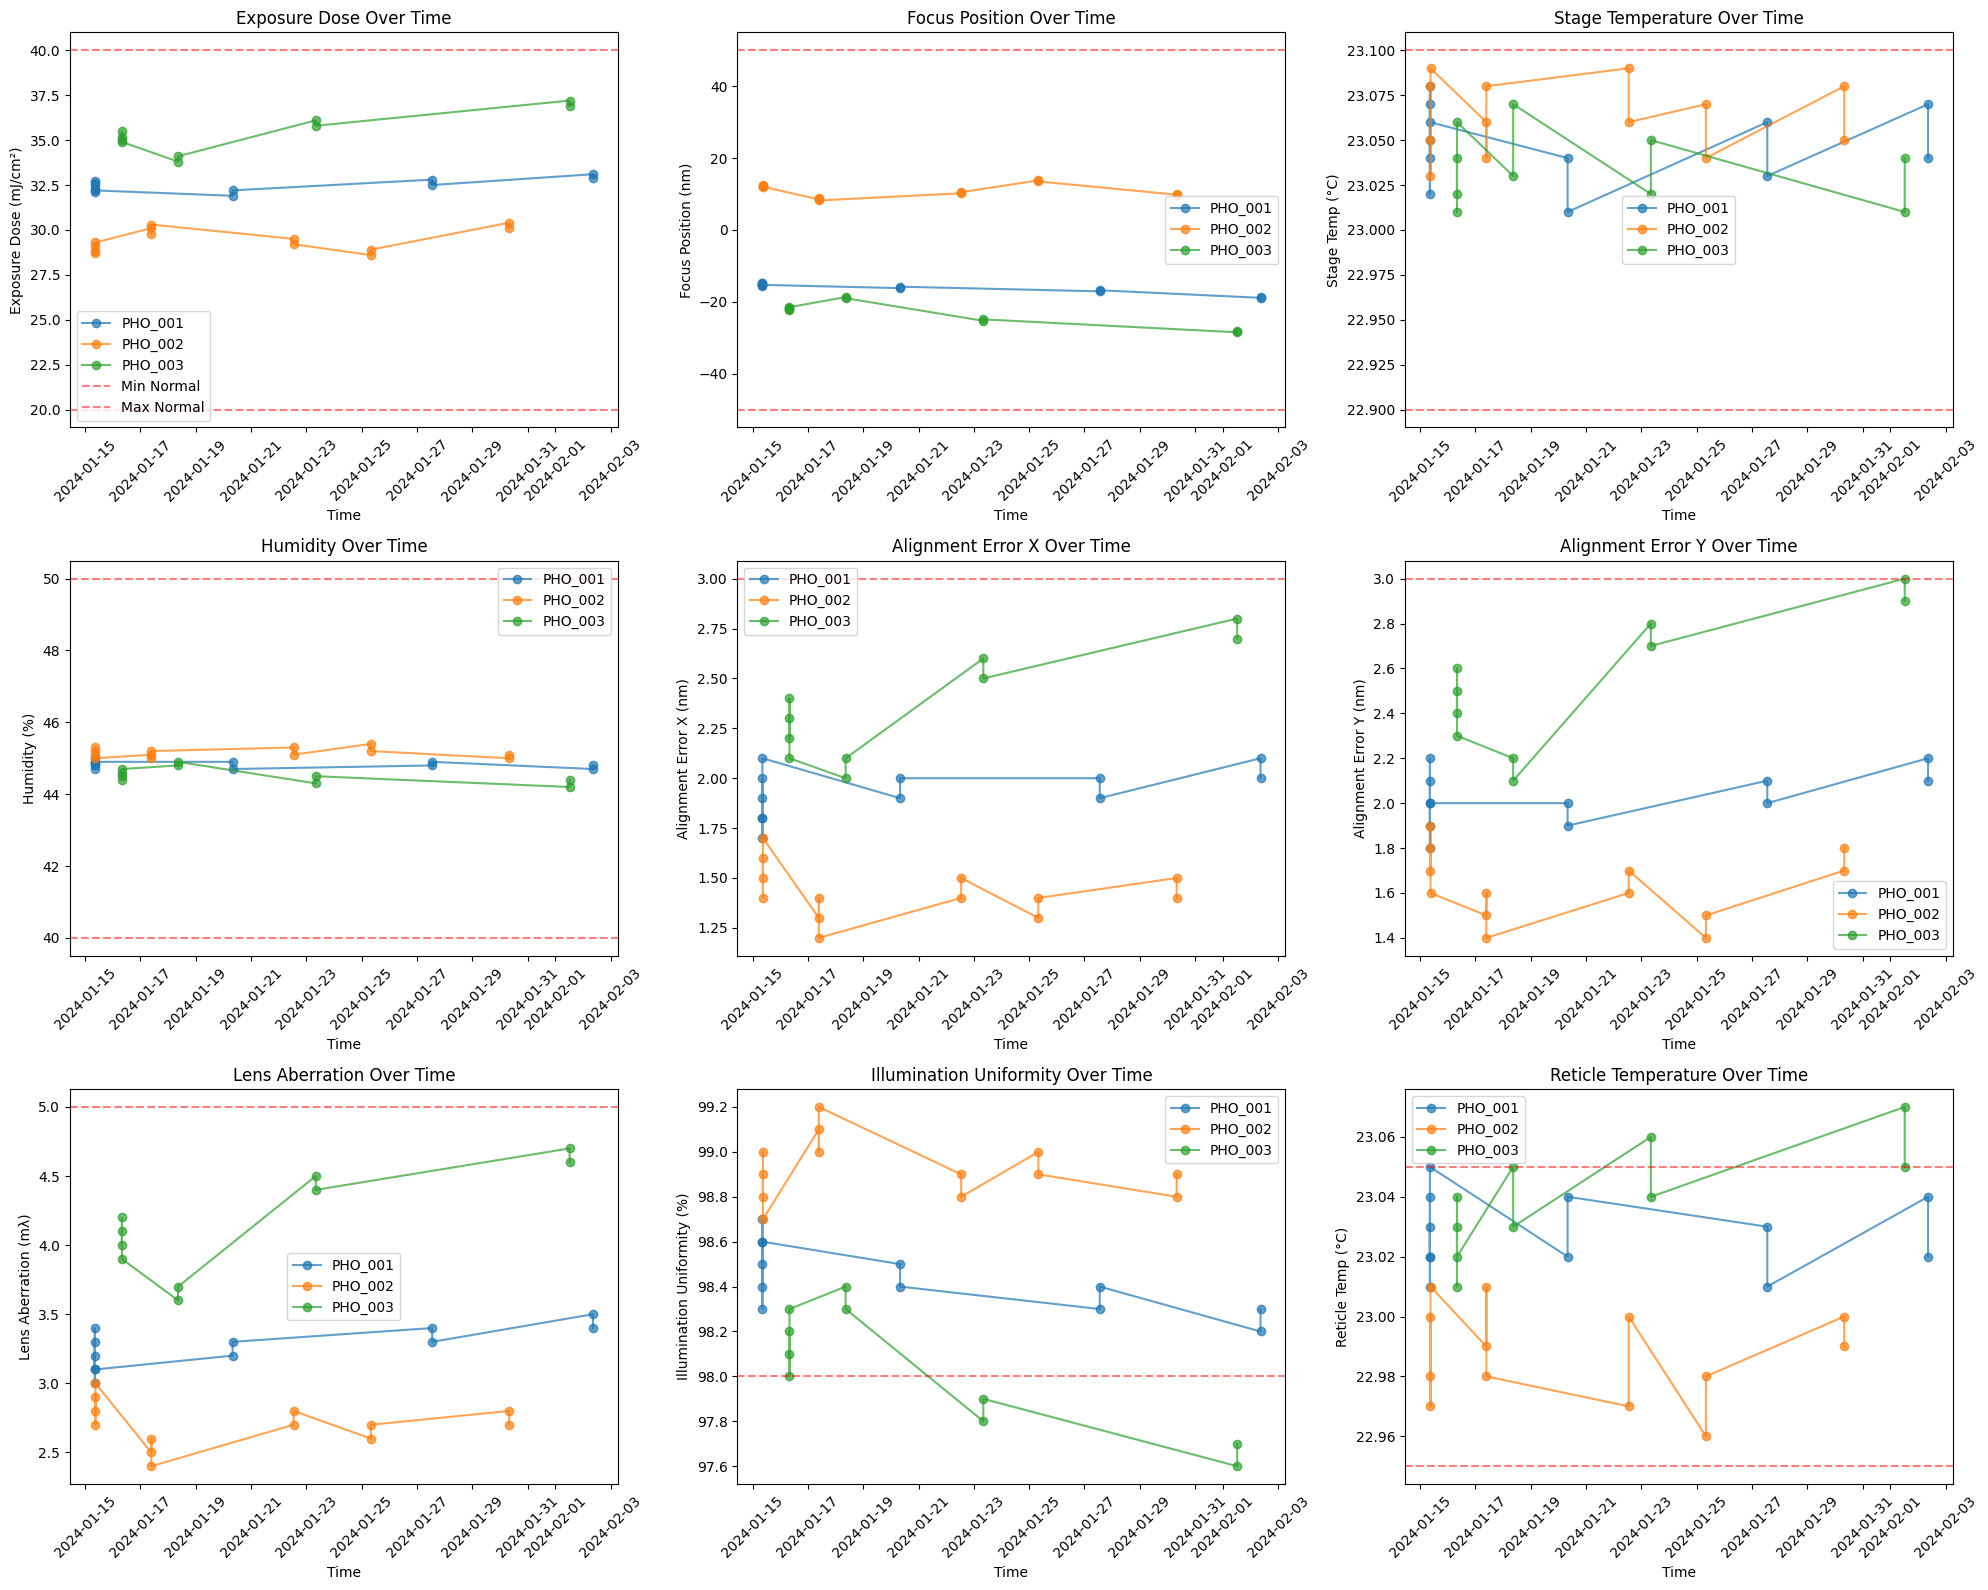

In [10]:
# 9. 데이터 시각화
print("\n9. 데이터 시각화")
print("-" * 50)

# 그래프 설정
plt.style.use('default')
fig = plt.figure(figsize=(20, 16))

# 1) 시간별 주요 파라미터 트렌드
plt.subplot(3, 3, 1)
for equipment in df['EQUIPMENT_ID'].unique():
    eq_data = df[df['EQUIPMENT_ID'] == equipment]
    plt.plot(eq_data['TIMESTAMP'], eq_data['EXPOSURE_DOSE'], 
             marker='o', label=equipment, alpha=0.7)
plt.axhline(y=20, color='red', linestyle='--', alpha=0.5, label='Min Normal')
plt.axhline(y=40, color='red', linestyle='--', alpha=0.5, label='Max Normal')
plt.title('Exposure Dose Over Time')
plt.xlabel('Time')
plt.ylabel('Exposure Dose (mJ/cm²)')
plt.legend()
plt.xticks(rotation=45)

# 2) 포커스 위치 트렌드
plt.subplot(3, 3, 2)
for equipment in df['EQUIPMENT_ID'].unique():
    eq_data = df[df['EQUIPMENT_ID'] == equipment]
    plt.plot(eq_data['TIMESTAMP'], eq_data['FOCUS_POSITION'], 
             marker='o', label=equipment, alpha=0.7)
plt.axhline(y=-50, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=50, color='red', linestyle='--', alpha=0.5)
plt.title('Focus Position Over Time')
plt.xlabel('Time')
plt.ylabel('Focus Position (nm)')
plt.legend()
plt.xticks(rotation=45)

# 3) 스테이지 온도 트렌드
plt.subplot(3, 3, 3)
for equipment in df['EQUIPMENT_ID'].unique():
    eq_data = df[df['EQUIPMENT_ID'] == equipment]
    plt.plot(eq_data['TIMESTAMP'], eq_data['STAGE_TEMP'], 
             marker='o', label=equipment, alpha=0.7)
plt.axhline(y=22.9, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=23.1, color='red', linestyle='--', alpha=0.5)
plt.title('Stage Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Stage Temp (°C)')
plt.legend()
plt.xticks(rotation=45)

# 4) 습도 트렌드
plt.subplot(3, 3, 4)
for equipment in df['EQUIPMENT_ID'].unique():
    eq_data = df[df['EQUIPMENT_ID'] == equipment]
    plt.plot(eq_data['TIMESTAMP'], eq_data['HUMIDITY'], 
             marker='o', label=equipment, alpha=0.7)
plt.axhline(y=40, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=50, color='red', linestyle='--', alpha=0.5)
plt.title('Humidity Over Time')
plt.xlabel('Time')
plt.ylabel('Humidity (%)')
plt.legend()
plt.xticks(rotation=45)

# 5) 정렬 오차 X축
plt.subplot(3, 3, 5)
for equipment in df['EQUIPMENT_ID'].unique():
    eq_data = df[df['EQUIPMENT_ID'] == equipment]
    plt.plot(eq_data['TIMESTAMP'], eq_data['ALIGNMENT_ERROR_X'], 
             marker='o', label=equipment, alpha=0.7)
plt.axhline(y=3, color='red', linestyle='--', alpha=0.5)
plt.title('Alignment Error X Over Time')
plt.xlabel('Time')
plt.ylabel('Alignment Error X (nm)')
plt.legend()
plt.xticks(rotation=45)

# 6) 정렬 오차 Y축
plt.subplot(3, 3, 6)
for equipment in df['EQUIPMENT_ID'].unique():
    eq_data = df[df['EQUIPMENT_ID'] == equipment]
    plt.plot(eq_data['TIMESTAMP'], eq_data['ALIGNMENT_ERROR_Y'], 
             marker='o', label=equipment, alpha=0.7)
plt.axhline(y=3, color='red', linestyle='--', alpha=0.5)
plt.title('Alignment Error Y Over Time')
plt.xlabel('Time')
plt.ylabel('Alignment Error Y (nm)')
plt.legend()
plt.xticks(rotation=45)

# 7) 렌즈 수차
plt.subplot(3, 3, 7)
for equipment in df['EQUIPMENT_ID'].unique():
    eq_data = df[df['EQUIPMENT_ID'] == equipment]
    plt.plot(eq_data['TIMESTAMP'], eq_data['LENS_ABERRATION'], 
             marker='o', label=equipment, alpha=0.7)
plt.axhline(y=5, color='red', linestyle='--', alpha=0.5)
plt.title('Lens Aberration Over Time')
plt.xlabel('Time')
plt.ylabel('Lens Aberration (mλ)')
plt.legend()
plt.xticks(rotation=45)

# 8) 조명 균일도
plt.subplot(3, 3, 8)
for equipment in df['EQUIPMENT_ID'].unique():
    eq_data = df[df['EQUIPMENT_ID'] == equipment]
    plt.plot(eq_data['TIMESTAMP'], eq_data['ILLUMINATION_UNIFORMITY'], 
             marker='o', label=equipment, alpha=0.7)
plt.axhline(y=98, color='red', linestyle='--', alpha=0.5)
plt.title('Illumination Uniformity Over Time')
plt.xlabel('Time')
plt.ylabel('Illumination Uniformity (%)')
plt.legend()
plt.xticks(rotation=45)

# 9) 레티클 온도
plt.subplot(3, 3, 9)
for equipment in df['EQUIPMENT_ID'].unique():
    eq_data = df[df['EQUIPMENT_ID'] == equipment]
    plt.plot(eq_data['TIMESTAMP'], eq_data['RETICLE_TEMP'], 
             marker='o', label=equipment, alpha=0.7)
plt.axhline(y=22.95, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=23.05, color='red', linestyle='--', alpha=0.5)
plt.title('Reticle Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Reticle Temp (°C)')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('sensor_trends.png', dpi=300, bbox_inches='tight')
plt.show()


이상치 히트맵 생성


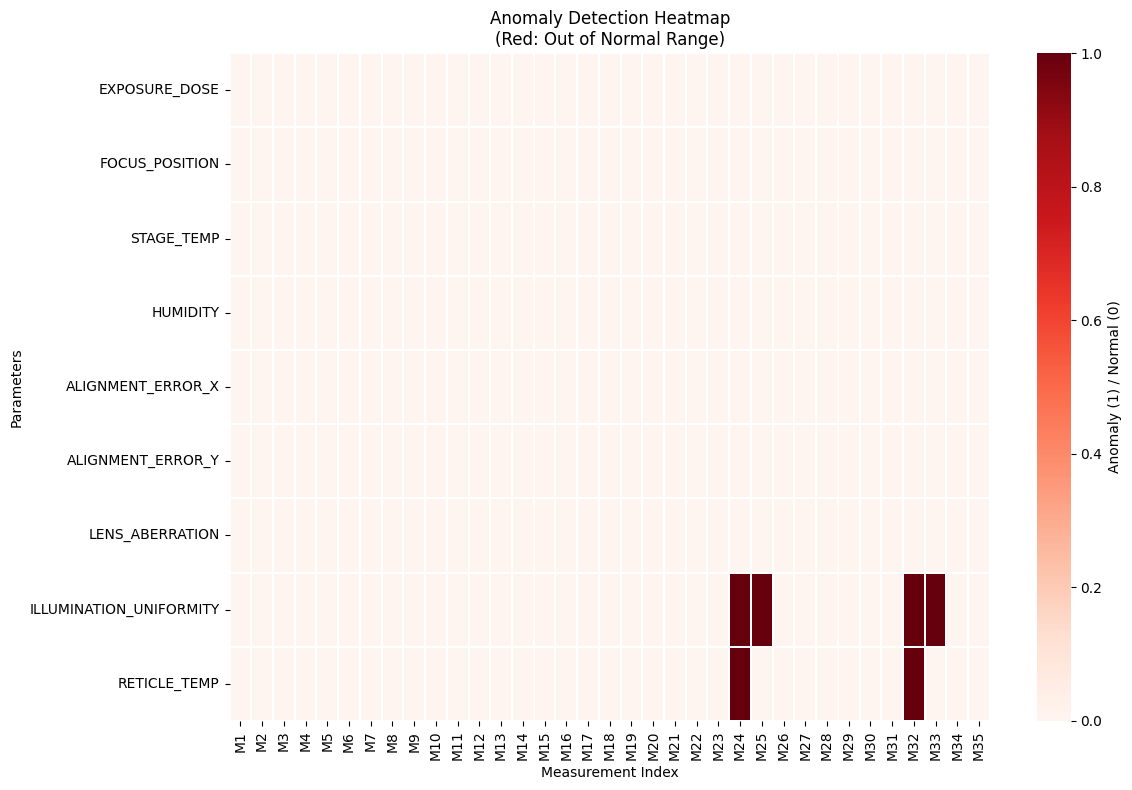

In [11]:
# 10. 이상치 히트맵
print("\n이상치 히트맵 생성")
plt.figure(figsize=(12, 8))

# 각 측정에 대해 정상 범위 벗어난 파라미터 수 계산
anomaly_matrix = np.zeros((len(df), len(normal_ranges)))
for i, (idx, row) in enumerate(df.iterrows()):
    for j, (param, (min_val, max_val)) in enumerate(normal_ranges.items()):
        if row[param] < min_val or row[param] > max_val:
            anomaly_matrix[i, j] = 1

# 히트맵 생성
sns.heatmap(anomaly_matrix.T, 
            xticklabels=[f"M{i+1}" for i in range(len(df))],
            yticklabels=list(normal_ranges.keys()),
            cmap='Reds', 
            cbar_kws={'label': 'Anomaly (1) / Normal (0)'},
            linewidths=0.1)
plt.title('Anomaly Detection Heatmap\n(Red: Out of Normal Range)')
plt.xlabel('Measurement Index')
plt.ylabel('Parameters')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('anomaly_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
# 11. 최종 요약 리포트
print("\n" + "="*80)
print("최종 이상 탐지 요약 리포트")
print("="*80)

total_measurements = len(df)
total_possible_anomalies = total_measurements * len(normal_ranges)
total_detected_anomalies = sum(len(range_anomalies) for range_anomalies in [full_analysis['range_based_anomalies']['details']])

print(f"분석 기간: {df['TIMESTAMP'].min()} ~ {df['TIMESTAMP'].max()}")
print(f"총 측정 건수: {total_measurements}")
print(f"분석 파라미터 수: {len(normal_ranges)}")
print(f"총 가능한 측정 포인트: {total_possible_anomalies}")
print(f"탐지된 이상치: {total_detected_anomalies}")
print(f"전체 이상률: {(total_detected_anomalies/total_possible_anomalies)*100:.2f}%")

print(f"\n장비별 성능:")
for equipment, perf in equipment_performance.items():
    print(f"  {equipment}: 이상률 {perf['anomaly_rate']:.2f}%")

print(f"\n파라미터별 이상 건수:")
if full_analysis['range_based_anomalies']['summary']:
    for param, summary in full_analysis['range_based_anomalies']['summary'].items():
        print(f"  {param}: {summary['count']}건 ({summary['percentage']:.1f}%)")

print(f"\n권장사항:")
if total_detected_anomalies > 0:
    print("  - 이상치가 탐지되었습니다. 해당 장비와 공정 파라미터를 점검하세요.")
    print("  - 특히 이상률이 높은 장비에 대한 예방정비를 고려하세요.")
    print("  - 정상 범위를 벗어난 파라미터들의 원인 분석을 수행하세요.")
else:
    print("  - 모든 측정값이 정상 범위 내에 있습니다.")
    print("  - 현재 공정 상태가 양호합니다.")

print("\n함수 사용 예시:")
print("# 특정 시간 구간 이상 탐지")
print("result = comprehensive_anomaly_detection(df, '2024-01-15 08:00:00', '2024-01-15 09:00:00')")
print("print(f'상태: {result[\"overall_status\"]}')")
print("print(f'이상치 건수: {result[\"range_based_anomalies\"][\"count\"]}')")

print("\n# 다른 CSV 파일 분석하기")
print("# 1. 상단의 CSV_FILE_PATH 변수를 다른 경로로 변경")
print("# 2. 셀을 다시 실행")
print("# 또는 직접 함수 호출:")
print("# new_df = pd.read_csv('new_file_path.csv')")
print("# new_df['TIMESTAMP'] = pd.to_datetime(new_df['TIMESTAMP'])")
print("# result = comprehensive_anomaly_detection(new_df)")



최종 이상 탐지 요약 리포트
분석 기간: 2024-01-15 08:30:15 ~ 2024-02-02 08:46:05
총 측정 건수: 35
분석 파라미터 수: 9
총 가능한 측정 포인트: 315
탐지된 이상치: 6
전체 이상률: 1.90%

장비별 성능:
  PHO_001: 이상률 0.00%
  PHO_002: 이상률 0.00%
  PHO_003: 이상률 6.67%

파라미터별 이상 건수:
  ILLUMINATION_UNIFORMITY: 4건 (11.4%)
  RETICLE_TEMP: 2건 (5.7%)

권장사항:
  - 이상치가 탐지되었습니다. 해당 장비와 공정 파라미터를 점검하세요.
  - 특히 이상률이 높은 장비에 대한 예방정비를 고려하세요.
  - 정상 범위를 벗어난 파라미터들의 원인 분석을 수행하세요.

함수 사용 예시:
# 특정 시간 구간 이상 탐지
result = comprehensive_anomaly_detection(df, '2024-01-15 08:00:00', '2024-01-15 09:00:00')
print(f'상태: {result["overall_status"]}')
print(f'이상치 건수: {result["range_based_anomalies"]["count"]}')

# 다른 CSV 파일 분석하기
# 1. 상단의 CSV_FILE_PATH 변수를 다른 경로로 변경
# 2. 셀을 다시 실행
# 또는 직접 함수 호출:
# new_df = pd.read_csv('new_file_path.csv')
# new_df['TIMESTAMP'] = pd.to_datetime(new_df['TIMESTAMP'])
# result = comprehensive_anomaly_detection(new_df)
